In [1]:
import os


def warn(*args, **kwargs):
    pass


import warnings

warnings.warn = warn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from pickle import dump

In [37]:
folders = ['vm/5high-5low/0iid',
           'vm/5high-5low/40iid', 'vm/5high-5low/100iid',
           'vm/3high-3low/0iid', 'vm/3high-3low/100iid',
           'vm/10high-10low/0iid', 'vm/10high-10low/100iid',
           'vm/4high-2low/0iid', 'vm/4high-2low/100iid',
           'vm/2high-4low/0iid', 'vm/2high-4low/100iid',
           'vm/2high-8low/0iid', 'vm/2high-8low/100iid']
exp_data: pd.DataFrame = pd.DataFrame()

for folder in folders:
    experiments = [subfolder for subfolder in os.listdir(os.getcwd() + '/' + folder)]
    for exp in experiments:
        exp_path = os.getcwd() + '/' + folder + '/' + exp
        if 'FLwithAP_performance_metrics.csv' in os.listdir(exp_path):
            df = pd.read_csv(exp_path + '/FLwithAP_performance_metrics.csv')
            df['F1/Time'] = df['Val F1'] / df['Total Time of FL Round']
            df = df[df['Val F1'] >= 0]
            df['N. Clients'] = df.apply(lambda x: x['Client ID'].split('Client ')[1].split('\n')[0], axis=1)
            last_client = [int(x) for x in df['N. Clients'].unique()]
            df['High-Spec Clients'] = int(folder.split('/')[1].split('high-')[0])
            df['Low-Spec Clients'] = int(folder.split('/')[1].split('high-')[1].split('low')[0])
            # print(folder, exp, last_client, df['High-Spec Clients'].unique(), df['Low-Spec Clients'].unique())
            df['Previous Val F1'] = df.shift(1)['Val F1']
            df['Previous F1/Time'] = df.shift(1)['F1/Time']
            df['IID Data'] = int(folder.split('/')[-1].split('iid')[0])
            df = df[df['FL Round'] > 1]
            df['Selector'] = df['N. Clients'].apply(lambda n: int(n) == min(last_client))
            df = df[['High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'Selector', 'Total Time of FL Round',
                     'Previous F1/Time', 'Previous Val F1', 'F1/Time', 'Val F1']]
            exp_data = pd.concat([exp_data, df])

print(exp_data)

     High-Spec Clients  Low-Spec Clients  IID Data  Selector  \
9                    5                 5         0      True   
14                   5                 5         0      True   
24                   5                 5         0     False   
29                   5                 5         0      True   
39                   5                 5         0     False   
..                 ...               ...       ...       ...   
159                  2                 8       100      True   
169                  2                 8       100      True   
179                  2                 8       100      True   
189                  2                 8       100      True   
199                  2                 8       100      True   

     Total Time of FL Round  Previous F1/Time  Previous Val F1   F1/Time  \
9                     53.85          0.002050           0.1207  0.003357   
14                    52.99          0.003357           0.1808  0.004510   
24 

In [69]:
from sklearn.model_selection import train_test_split

x_train = exp_data[['IID Data', 'Selector', 'Previous Val F1']]
y_train = exp_data[['Total Time of FL Round', 'Val F1']]

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.01)
model_f1 = LinearRegression()
model_f1.fit(x_train, y_train)

with open("../predictors/f1_linear_regressor.pkl", "wb") as f:
    dump(model_f1, f, protocol=5)

tree_f1 = DecisionTreeRegressor(max_depth=20)
tree_f1.fit(x_train, y_train)

with open("../predictors/f1_tree_regressor.pkl", "wb") as f:
    dump(tree_f1, f, protocol=5)

x_train = exp_data[['IID Data', 'Selector', 'Previous F1/Time']]
y_train = exp_data[['Total Time of FL Round', 'F1/Time']]

model_f1overtime = LinearRegression()
model_f1overtime.fit(x_train, y_train)

with open("../predictors/f1overtime_linear_regressor.pkl", "wb") as f:
    dump(model_f1overtime, f, protocol=5)

x = exp_data[['High-Spec Clients', 'Low-Spec Clients', 'Selector', 'Previous F1/Time']]
y = exp_data[['Total Time of FL Round', 'F1/Time']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

tree_f1overtime = DecisionTreeRegressor(max_depth=12)
tree_f1overtime.fit(x_train, y_train)

print(tree_f1overtime.score(x_train, y_train))
print(tree_f1overtime.score(x_test, y_test))

with open("../predictors/f1overtime_tree_regressor.pkl", "wb") as f:
    dump(tree_f1overtime, f, protocol=5)

     High-Spec Clients  Low-Spec Clients  Selector  Previous F1/Time
3                    2                 8      True          0.001425
51                   4                 2     False          0.006718
39                   5                 5      True          0.005177
85                   2                 8     False          0.008458
59                   2                 4     False          0.010476
..                 ...               ...       ...               ...
35                   2                 8      True          0.006727
84                   5                 5      True          0.007533
199                  2                 8      True          0.008032
71                   2                 8      True          0.009584
65                   2                 8      True          0.006030

[1824 rows x 4 columns]
     Total Time of FL Round   F1/Time
3                     54.03  0.003848
51                    60.23  0.006113
39                    58.83  0.00

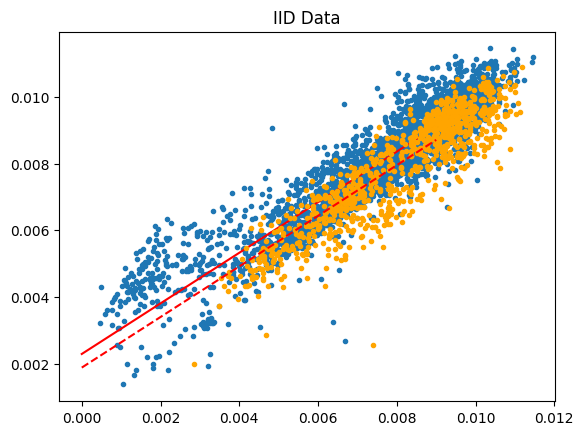

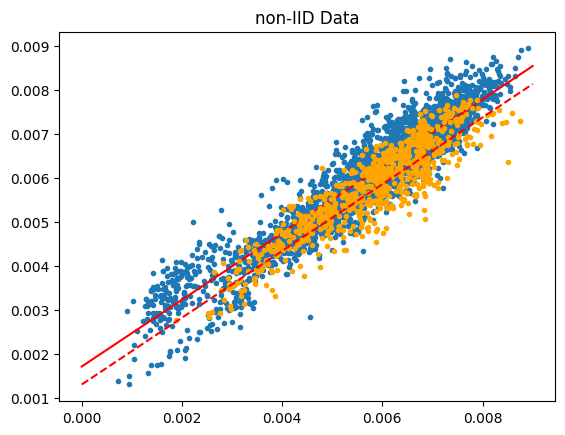

In [66]:
x = np.arange(0, 0.01, 0.001)
plot_data = exp_data[['IID Data', 'Selector', 'Previous F1/Time', 'F1/Time']].values.tolist()

plt.figure()

x_train = [i[2] for i in plot_data if i[0] and i[1]]
y_train = [i[3] for i in plot_data if i[0] and i[1]]
plt.plot(x_train, y_train, '.')
plt.plot(x, [model_f1overtime.predict([[100, True, v]])[0][1] for v in x], color='red')

x_train = [i[2] for i in plot_data if i[0] and not i[1]]
y_train = [i[3] for i in plot_data if i[0] and not i[1]]
plt.plot(x_train, y_train, '.', color='orange')
plt.plot(x, [model_f1overtime.predict([[100, False, v]])[0][1] for v in x], '--', color='red')

plt.title('IID Data')
# plt.ylim(0, 0.007)

plt.show()

plt.figure()

x_train = [i[2] for i in plot_data if not i[0] and i[1]]
y_train = [i[3] for i in plot_data if not i[0] and i[1]]
plt.plot(x_train, y_train, '.')
plt.plot(x, [model_f1overtime.predict([[0, True, v]])[0][1] for v in x], color='red')

x_train = [i[2] for i in plot_data if not i[0] and not i[1]]
y_train = [i[3] for i in plot_data if not i[0] and not i[1]]
plt.plot(x_train, y_train, '.', color='orange')
plt.plot(x, [model_f1overtime.predict([[0, False, v]])[0][1] for v in x], '--', color='red')

plt.title('non-IID Data')
# plt.ylim(0, 0.007)

plt.show()

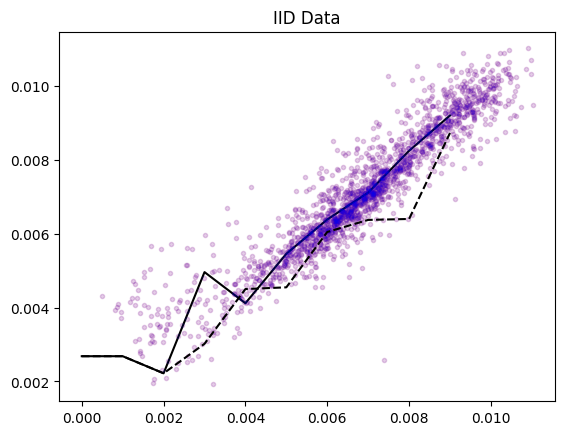

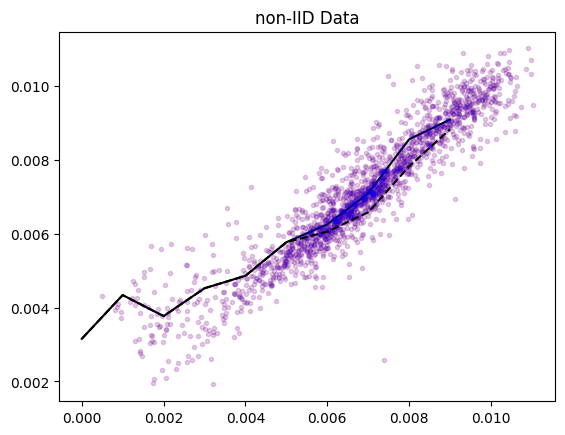

In [71]:
x = np.arange(0, 0.01, 0.001)
plot_data = exp_data[['High-Spec Clients', 'Low-Spec Clients', 'Selector',
                      'Previous F1/Time', 'F1/Time']].values.tolist()

plt.figure()

x_plot = x_test[x_test['Selector']]
y_train = [i[4] for i in plot_data if i[2]]
plt.plot(x_test['Previous F1/Time'], y_test['F1/Time'], '.', color='red', alpha=0.1)
plt.plot(x, [tree_f1overtime.predict([[10, 10, True, v]])[0][1] for v in x], color="black")

x_train = [i[3] for i in plot_data if not i[2]]
y_train = [i[4] for i in plot_data if not i[2]]
plt.plot(x_test['Previous F1/Time'], y_test['F1/Time'], '.', color='blue', alpha=0.1)
plt.plot(x, [tree_f1overtime.predict([[10, 10, False, v]])[0][1] for v in x], '--', color="black")

plt.title('IID Data')
# plt.ylim(0, 0.007)

plt.show()

plt.figure()

x_train = [i[3] for i in plot_data if i[2]]
y_train = [i[4] for i in plot_data if i[2]]
plt.plot(x_test['Previous F1/Time'], y_test['F1/Time'], '.', color='red', alpha=0.1)
plt.plot(x, [tree_f1overtime.predict([[2, 8, True, v]])[0][1] for v in x], color="black")

x_train = [i[3] for i in plot_data if not i[2]]
y_train = [i[4] for i in plot_data if not i[2]]
plt.plot(x_test['Previous F1/Time'], y_test['F1/Time'], '.', color='blue', alpha=0.1)
plt.plot(x, [tree_f1overtime.predict([[2, 8, False, v]])[0][1] for v in x], '--', color="black")

plt.title('non-IID Data')
# plt.ylim(0, 0.007)

plt.show()